# Goal of this notebook is to scale through a cluster to calculate NDVI across 128+ Landsat Scenes (using DASK)

(https://landsat.usgs.gov/landsat_acq)
Use the tools on this page to determine when the Landsat 7 and Landsat 8 satellites acquire data over your area of interest, and to view the paths that were acquired on any given day. 

Landsat satellites image the entire Earth every 16 days in an 8-day offset. Landsat 7 acquires data in descending (daytime) node, while Landsat 8 acquires data in both descending and occasional ascending (nighttime) node. 

The Landsat 8 satellite orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi), inclined at 98.2 degrees, and circles the Earth every 99 minutes. The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.

Landsat satellites image the entire Earth every 16 days in an 8-day offset. Landsat 7 acquires data in descending (daytime) node, while Landsat 8 acquires data in both descending and occasional ascending (nighttime) node. 

Row refers to the latitudinal center line of a frame of imagery. As the satellite moves along its path, the observatory instruments are continuously scanning the terrain below.  These will be squares centered on the orbital path, but tilted clockwise when views on the UTM projection used for the distributed data.

In [1]:
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1/'
redband = url+'LC08_L1TP_227065_20200608_20200626_01_T1_B{}.TIF'.format(4)

In [2]:
!wget {redband}

--2021-01-17 19:46:08--  http://landsat-pds.s3.amazonaws.com/c1/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1/LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF
Resolving landsat-pds.s3.amazonaws.com (landsat-pds.s3.amazonaws.com)... 52.218.169.19
Connecting to landsat-pds.s3.amazonaws.com (landsat-pds.s3.amazonaws.com)|52.218.169.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59222647 (56M) [image/tiff]
Saving to: ‘LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF.13’

LC08_L1TP_227065_20 100%[===================>]  56.48M  98.7MB/s    in 0.6s    

2021-01-17 19:46:09 (98.7 MB/s) - ‘LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF.13’ saved [59222647/59222647]



In [3]:
!gdalinfo LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF

Driver: GTiff/GeoTIFF
Files: LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF
Size is 7621, 7761
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 21N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 21N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-57,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
         

In [4]:
import xarray as xa
red = xa.open_rasterio('LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF')

In [5]:
red.crs

'+init=epsg:32621'

In [6]:
red.shape[2],red.shape[1]

(7621, 7761)

In [7]:
red.transform

(30.0, 0.0, 573285.0, 0.0, -30.0, -683685.0)

In [8]:
import gdal
from gdalconst import GA_ReadOnly

data = gdal.Open('LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF', GA_ReadOnly)
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print ([minx, miny, maxx, maxy])
data = None

[573285.0, -916515.0, 801915.0, -683685.0]


EPSG:4326
WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS

Reproject "EPSG",32621 to EPSG:4326

Lets find the bounding box for the region

In [9]:
from osgeo import gdal

input_raster=gdal.Open('LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF')
output_raster = "Reproj" + 'LC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF'
gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7feff36bfa20> >

In [10]:
data = gdal.Open('ReprojLC08_L1TP_227065_20200608_20200626_01_T1_B4.TIF', GA_ReadOnly)
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print ([minx, miny, maxx, maxy])
data = None

[-56.33759064732078, -8.290860873734873, -54.2594726602711, -6.178270448812246]


If you have trouble getting the right scene to cover the area you want:

Go to https://landsat.usgs.gov/wrs-2-pathrow-latitudelongitude-converter  and enter the lat/long. 
Then note the path row, and when you get the Landsat data, insure you have the correct path and row, which are listed in the download table.
Use https://landsat.usgs.gov/landsat_acq tool, which will show the coverage for each data
Path/Row shapefiles and KML: https://www.usgs.gov/land-resources/nli/landsat/landsat-shapefiles-and-kml-files
KML file direct download:https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/WRS-2_bound_world_0.kml

In [11]:
#get list of images
import requests
from bs4 import BeautifulSoup
import re
URL = 'https://landsatonaws.com/L8/227/065/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

In [12]:
# Use beautiful soup to extract all the links, and Tier 1 only
LevelOnes=[]
for link in soup.findAll('a', attrs={'href': re.compile("^/L8/227/065")}):
    #print(link.get('href'))
    href = link.get('href')
    if href.endswith("T1"):
        LevelOnes.append(href)

In [13]:
len(LevelOnes)

133

In [14]:
# Base links
LevelOnes

['/L8/227/065/LC08_L1TP_227065_20201201_20201217_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20201115_20201210_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200928_20201007_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200912_20200920_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200827_20200905_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200827_20200905_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200811_20200822_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200726_20200807_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200710_20200721_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200624_20200707_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200608_20200626_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200523_20200607_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200507_20200509_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200405_20200410_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20200217_20200225_01_T1',
 '/L8/227/065/LC08_L1TP_227065_20191215_20201023_01_T1',
 '/L8/227/065/LC08_L1TP_227065_

In [15]:
# Lets add Band 4 (Red) only
base="s3://landsat-pds/c1"
redlinks=[]
baselinks=[]
for link in LevelOnes:
    #print(link.split('/')[4])
    redband = base+link+"/"+link.split('/')[4]+'_B{}.TIF'.format(4)
    baselink = base+link+"/"+link.split('/')[4]
    baselinks.append(baselink)
    redlinks.append(redband)

In [16]:
 #baselinks

In [17]:
redlinks[0]

's3://landsat-pds/c1/L8/227/065/LC08_L1TP_227065_20201201_20201217_01_T1/LC08_L1TP_227065_20201201_20201217_01_T1_B4.TIF'

In [18]:
baselinks[0]

's3://landsat-pds/c1/L8/227/065/LC08_L1TP_227065_20201201_20201217_01_T1/LC08_L1TP_227065_20201201_20201217_01_T1'

In [19]:
import rasterio
print('Landsat on AWS:')
with rasterio.open(redlinks[0]) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7621, 'height': 7761, 'count': 1, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 573285.0,
       0.0, -30.0, -683685.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Writing a DASK task which calculates NDVI of each pixel in the large scene

Calculate and display NDVI : Uses the MTL to calculate Landsat scene's image as reflectance values, and then we are ready to compute NDVI.

𝑁𝐷𝑉𝐼=𝑁𝐼𝑅−𝑅𝑒𝑑𝑁𝐼𝑅+𝑅𝑒𝑑, highlights areas of healthy vegetation with high NDVI values, which appear as green in the image below.

The Landsat Level 1 images are delivered in a quantized format. 
This has to be converted to top-of-atmosphere reflectance using the provided metadata.

## Be warned that TOA reflectance with a correction for the sun angle is not done

# Conversion to TOA Reflectance
### Ref - https://www.usgs.gov/core-science-systems/nli/landsat/using-usgs-landsat-level-1-data-product
Reflective band DN’s can be converted to TOA reflectance using the rescaling coefficients in the MTL file:  

ρλ′=Mρ * Qcal+Aρ

where:

ρλ'   = TOA planetary reflectance, without correction for solar angle.  Note that ρλ' does not contain a correction for the sun angle.

Mρ=Band-specific multiplicative rescaling factor from the metadata (REFLECTANCE_MULT_BAND_x, where x is the band number)

Aρ  =Band-specific additive rescaling factor from the metadata (REFLECTANCE_ADD_BAND_x, where x is the band number) 

Qcal =  Quantized and calibrated standard product pixel values (DN)

TOA reflectance with a correction for the sun angle is then:

ρλ=ρλ′cos(θSZ)=ρλ′sin(θSE)

where:

ρλ=  TOA planetary reflectance
θSE =  Local sun elevation angle. 
The scene center sun elevation angle in degrees is provided in the metadata (SUN_ELEVATION).
θSZ =Local solar zenith angle;  θSZ = 90° - θSE

For more accurate reflectance calculations, per-pixel solar angles could be used instead of the scene center solar angle. 
While per-pixel solar zenith angles are not provided with the Landsat Level-1 products, tools are provided which allow users to create angle bands.

In [20]:
import dask
import xarray as xa
import os
import json
import rasterio
import requests

def calculate_ndvi(item):
    # Get MTL 
    #https://landsat-pds.s3.amazonaws.com
    mtl = item +'_MTL.json'
    # A hack to get the path to download the MTL file
    mtl = mtl.replace("s3://landsat-pds", "https://landsat-pds.s3.amazonaws.com")
    if not os.path.exists(mtl):
        print("Downloading", mtl)
        response = requests.get(mtl)
        out_filename = mtl.split('.')[3].split('/')[6]+'.json'
        with open(out_filename, 'wb') as f:
            f.write(response.content)
    # The Landsat Level 1 images are delivered in a quantized format. 
    # This has to be converted to top-of-atmosphere reflectance using the provided metadata.  
    
    # One MTL file for a scene - bundled with a list of Band specific TIFF files
    with open(out_filename) as f:
        metadata = json.load(f)
        # M_p for Red
        band_number = 4
        M_p_red = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
        band_number = 5
        M_p_nir = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
        band_number = 4
        A_p_red = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
        band_number = 5
        A_p_nir = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
    
    
    # +'_B{}.TIF'.format(4)
    redband = item +'_B{}.TIF'.format(4)
    nirband = item +'_B{}.TIF'.format(5)
    
    # read red and nir
    red = xa.open_rasterio(redband, chunks={'band': 1, 'x': 1024, 'y': 1024})
    nir = xa.open_rasterio(nirband, chunks={'band': 1, 'x': 1024, 'y': 1024})
    
    red_toa = M_p_red * red + A_p_red
    nir_toa = M_p_nir * nir + A_p_nir
    
    ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)
    
    #export ndvi image
    #ndviImage = rasterio.open(item+'ndviImage.tiff','w',driver='Gtiff',
    #                      width=red.shape[2], 
    #                      height = red.shape[1], 
    #                      count=1, crs=red.crs, 
    #                      transform=red.transform, 
    #                      dtype='float64')
    #ndviImage.write(ndvi,1)
    #ndviImage.close()

    return ndvi

In [21]:
ndvi_datasets = []
for item in baselinks:
    ds = calculate_ndvi(item)
    ndvi_datasets.append(ds)



# Visualize the dataset

In [22]:
ndvi_datasets[0]

<xarray.DataArray (band: 1, y: 7761, x: 7621)>
dask.array<truediv, shape=(1, 7761, 7621), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -6.837e+05 -6.837e+05 ... -9.165e+05 -9.165e+05
  * x        (x) float64 5.733e+05 5.733e+05 5.734e+05 ... 8.019e+05 8.019e+05

## Missing datetime, so tempral analysis not possible, lets add it

# Expand the dask array to tag the datetime

In [23]:
import pandas as pd
expanded_ndvi_datasets = []
#for ndvi_item in ndvi_datasets:
#    ndvi_exp_item = ndvi_item.expand_dims(time=[pd.to_datetime(baselinks[0].split('/')[8].split('_')[3], format='%Y%m%d', errors='ignore')])
#    expanded_ndvi_datasets.append(ndvi_exp_item)
    
    
index = 0

for link in baselinks:
    dtofcapture = link.split('/')[8].split('_')[3]
    expanded_ndvi_datasets.append(ndvi_datasets[index].expand_dims(time=[pd.to_datetime(dtofcapture, format='%Y%m%d', errors='ignore')]))
    index = index + 1

In [24]:
expanded_ndvi_datasets[123]

<xarray.DataArray (time: 1, band: 1, y: 7761, x: 7621)>
dask.array<broadcast_to, shape=(1, 1, 7761, 7621), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2014-03-20
  * band     (band) int64 1
  * y        (y) float64 -6.837e+05 -6.837e+05 ... -9.165e+05 -9.165e+05
  * x        (x) float64 5.733e+05 5.733e+05 5.734e+05 ... 8.019e+05 8.019e+05

In [25]:
len(expanded_ndvi_datasets)

133

# Lets inspect NDVI of sample scene

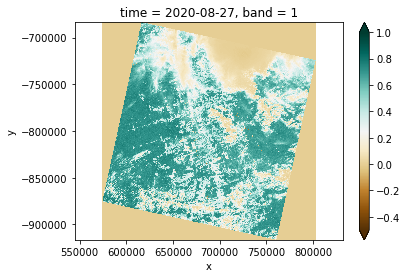

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
im = expanded_ndvi_datasets[4].squeeze().compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()

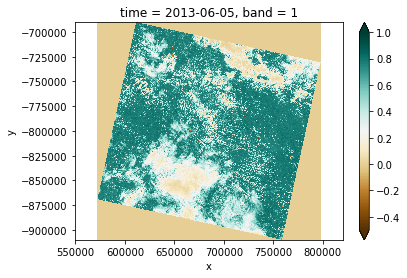

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
im = expanded_ndvi_datasets[131].squeeze().compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()

In [40]:
expanded_ndvi_datasets[131]

<xarray.DataArray (time: 1, band: 1, y: 7321, x: 7521)>
dask.array<broadcast_to, shape=(1, 1, 7321, 7521), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-06-05
  * band     (band) int64 1
  * y        (y) float64 -6.903e+05 -6.903e+05 ... -9.099e+05 -9.099e+05
  * x        (x) float64 5.718e+05 5.718e+05 5.719e+05 ... 7.974e+05 7.974e+05

## Be warned that TOA reflectance with a correction for the sun angle is not done

We got 133 images

In [28]:
# Save the files

import datacube
from datacube.utils.cog import write_cog

In [29]:
expanded_ndvi_datasets[0].values

array([[[[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         ...,
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.]]]])

In [30]:
# Write GeoTIFF to a location
#write_cog(geo_im=expanded_ndvi_datasets[0]..squeeze(),
#          fname='ndvi_20200811.tif',
#          overwrite=True)

# Exploring holoview to visualize

 Each scene's task execution is delayed and the operations are parallelized automatically.

In [42]:
expanded_ndvi_datasets[0]

<xarray.DataArray (time: 1, band: 1, y: 7761, x: 7621)>
dask.array<broadcast_to, shape=(1, 1, 7761, 7621), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01
  * band     (band) int64 1
  * y        (y) float64 -6.837e+05 -6.837e+05 ... -9.165e+05 -9.165e+05
  * x        (x) float64 5.733e+05 5.733e+05 5.734e+05 ... 8.019e+05 8.019e+05

In [43]:
import hvplot.pandas  # noqa
import hvplot.dask  # noqa

In [33]:
ds_ndvi = expanded_ndvi_datasets[0].to_dataset(name="ndvi")

In [34]:
ds_ndvi

<xarray.Dataset>
Dimensions:  (band: 1, time: 1, x: 7621, y: 7761)
Coordinates:
  * time     (time) datetime64[ns] 2020-12-01
  * band     (band) int64 1
  * y        (y) float64 -6.837e+05 -6.837e+05 ... -9.165e+05 -9.165e+05
  * x        (x) float64 5.733e+05 5.733e+05 5.734e+05 ... 8.019e+05 8.019e+05
Data variables:
    ndvi     (time, band, y, x) float64 dask.array<chunksize=(1, 1, 1024, 1024), meta=np.ndarray>

In [35]:
## Creashes the kernel

In [36]:
#import hvplot.xarray  # noqa
#ds_ndvi.hvplot.image()

In [37]:
ndvi1 = expanded_ndvi_datasets[0].to_dataframe(name='ndvi')

In [38]:
ndvi1

ndvi
time       band y         x             
2020-12-01 1    -683700.0 573300.0  -0.0
                          573330.0  -0.0
                          573360.0  -0.0
                          573390.0  -0.0
                          573420.0  -0.0
...                                  ...
                -916500.0 801780.0  -0.0
                          801810.0  -0.0
                          801840.0  -0.0
                          801870.0  -0.0
                          801900.0  -0.0

[59146581 rows x 1 columns]

In [39]:
#ndvi1.plot()